In [89]:
import utils
import plotting
import numpy as np
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning

# ignore these because they don't seem to apply
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from PyPDF2 import PdfFileMerger


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
plot_dir = "../../../plots/ttsfs/"

import os
_ = os.system(f"mkdir -p {plot_dir}")

In [103]:
samples = {
    "QCD": "QCD",
    "Single Top": "ST",
    "TTSL": "TTToSemiLeptonic",
    "TTbar": ["TTTo2L2Nu", "TTToHadronic"],
    "W+Jets": "WJets",
    "Diboson": ["WW", "WZ", "ZZ"],
    "Data": "SingleMuon",
}

data_dir = "../../../../data/ttsfs/"
year = "2017"

# filters = [("('ak8FatJetPt', '0')", ">=", 500)]
filters = None

events_dict = utils.load_samples(data_dir, samples, year, filters=filters)

Finding QCD samples
Loading QCD_Pt_3200toInf
Loaded 0 entries
Loading QCD_Pt_1800to2400
Loaded 0 entries
Loading QCD_Pt_2400to3200
Loaded 1 entries
Loading QCD_Pt_1000to1400
Loaded 0 entries
Loading QCD_Pt_600to800
Loaded 0 entries
Loading QCD_Pt_300to470
Loaded 243 entries
Loading QCD_Pt_170to300
Loaded 0 entries
Loading QCD_Pt_800to1000
Loaded 127 entries
Loading QCD_Pt_470to600
Loaded 0 entries
Loading QCD_Pt_1400to1800
Loaded 0 entries
Finding Single Top samples
Loading ST_tW_antitop_5f_NoFullyHadronicDecays
Loaded 7273 entries
Loading ST_tW_top_5f_NoFullyHadronicDecays
Loaded 7422 entries
Loading ST_tW_top_5f_inclusiveDecays
Loaded 2700 entries
Loading ST_tW_antitop_5f_inclusiveDecays
Loaded 2607 entries
Loading ST_s-channel_4f_leptonDecays
Loaded 3309 entries
Finding TTSL samples
Loading TTToSemiLeptonic
Loaded 127839 entries
Loading TTToSemiLeptonic_ext1
Loaded 33194 entries
Finding TTbar samples
Loading TTTo2L2Nu
Loaded 82688 entries
Loading TTToHadronic
Loaded 328 entries
Find

In [104]:
events_dict["TT Top Matched"] = events_dict["TTSL"].loc[events_dict["TTSL"]["top_matched"][0] == 1]
events_dict["TT W Matched"] = events_dict["TTSL"].loc[events_dict["TTSL"]["w_matched"][0] == 1]
events_dict["TT Unmatched"] = pd.concat([events_dict["TTbar"], events_dict["TTSL"].loc[events_dict["TTSL"]["unmatched"][0] == 1]])
# del events_dict["TTSL"]
# del events_dict["TTbar"]

In [105]:
# normalize scale factors to average to 1
mean_lp_sf = np.mean(events_dict["TT Top Matched"]["lp_sf"][0])
events_dict["TT Top Matched"].loc[:, ("lp_sf", 0)] /= mean_lp_sf
events_dict["TT Top Matched"].loc[:, ("lp_sf_err", 0)] /= mean_lp_sf


In [107]:
for key in events_dict:
    if key == "TT Top Matched":
        events_dict[key]["total_weight"] = events_dict[key]["weight"] * events_dict[key]["lp_sf"]
        events_dict[key]["total_weight_err"] = events_dict[key]["weight"] * events_dict[key]["lp_sf_err"]
    else:
        events_dict[key]["total_weight"] = events_dict[key]["weight"]
        events_dict[key]["total_weight_err"] = events_dict[key]["weight"] * 0

In [120]:
for key in events_dict:
    events_dict[key] = events_dict[key][events_dict[key]["ak8FatJetPt"][0] >= 500]

In [123]:
plot_samples = ["QCD", "Diboson", "Single Top", "W+Jets", "TT Unmatched", "TT W Matched", "TT Top Matched"]

In [158]:
events_dict[key].columns

MultiIndex([(               'ak8FatJetEta',  0),
            (               'ak8FatJetEta',  1),
            (               'ak8FatJetPhi',  0),
            (               'ak8FatJetPhi',  1),
            (              'ak8FatJetMass',  0),
            (              'ak8FatJetMass',  1),
            (                'ak8FatJetPt',  0),
            (                'ak8FatJetPt',  1),
            (               'ak8FatJetMsd',  0),
            (               'ak8FatJetMsd',  1),
            ( 'ak8FatJetParticleNetMD_QCD',  0),
            ( 'ak8FatJetParticleNetMD_QCD',  1),
            ( 'ak8FatJetParticleNetMD_Xbb',  0),
            ( 'ak8FatJetParticleNetMD_Xbb',  1),
            (  'ak8FatJetParticleNet_Th4q',  0),
            (  'ak8FatJetParticleNet_Th4q',  1),
            (          'ak8FatJetnPFCands',  0),
            (          'ak8FatJetnPFCands',  1),
            (                      'tau21',  0),
            (                      'tau32',  0),
            (       

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


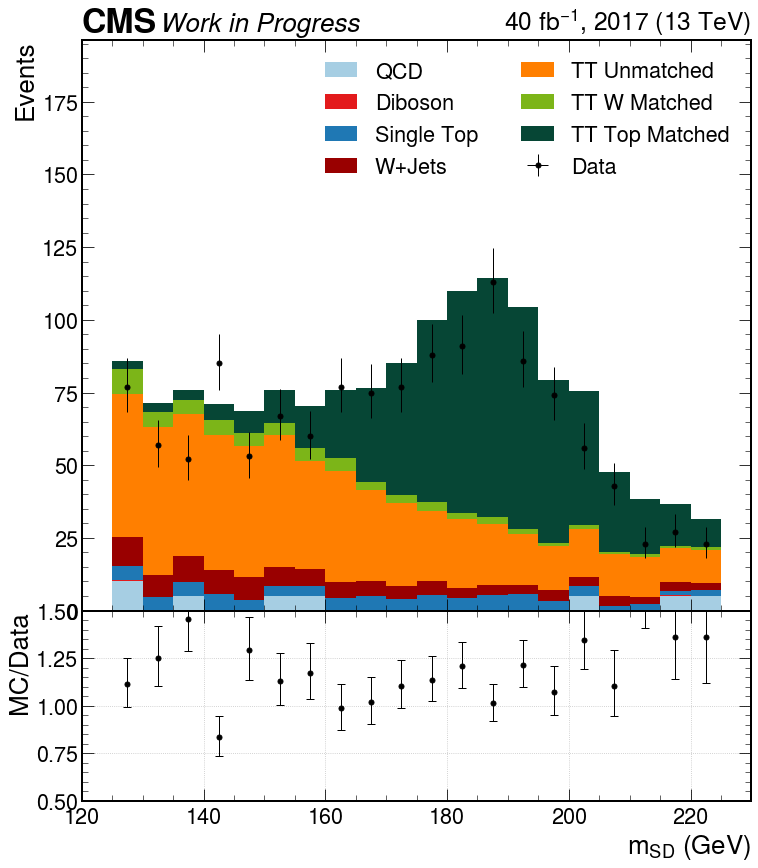

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


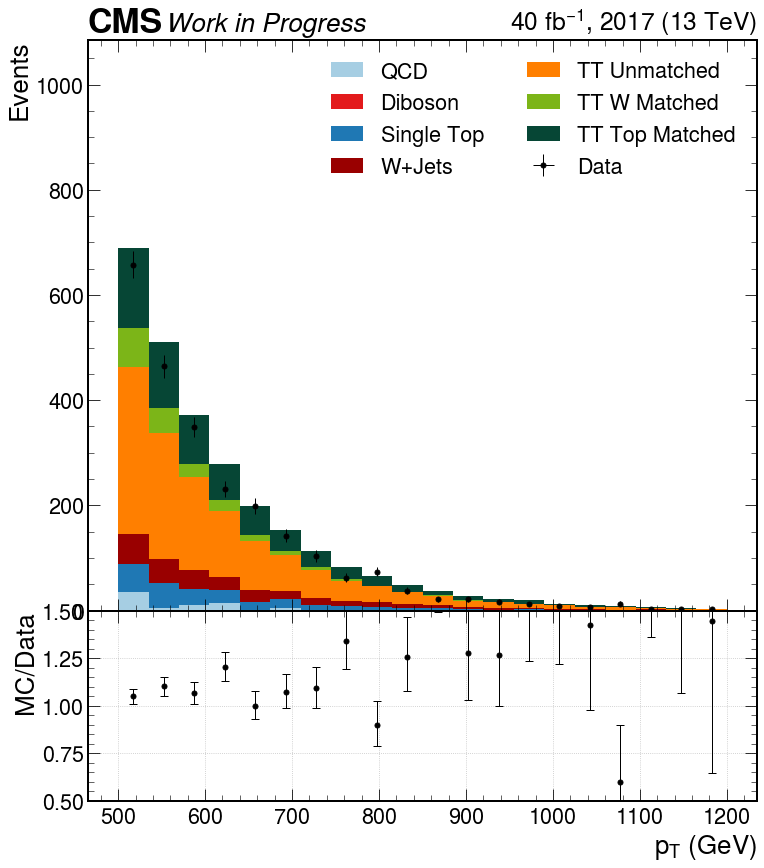

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


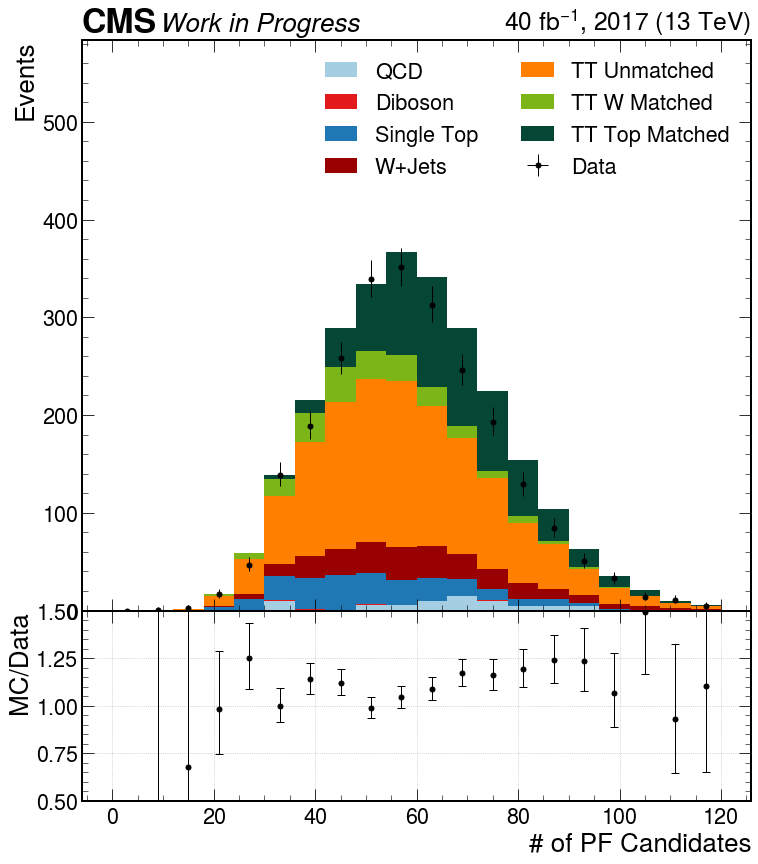

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


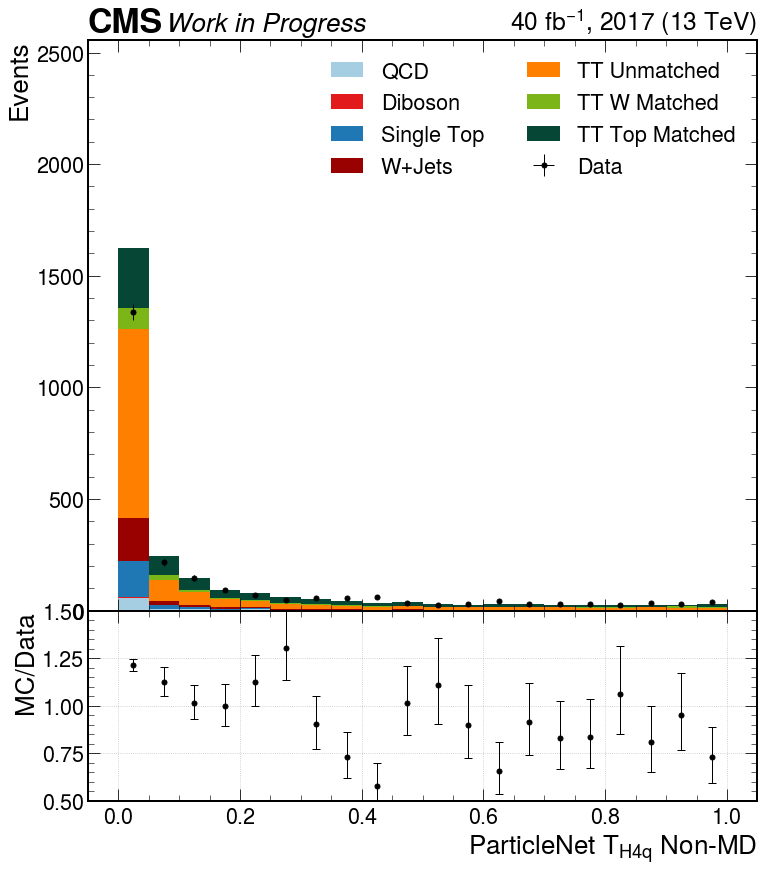

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


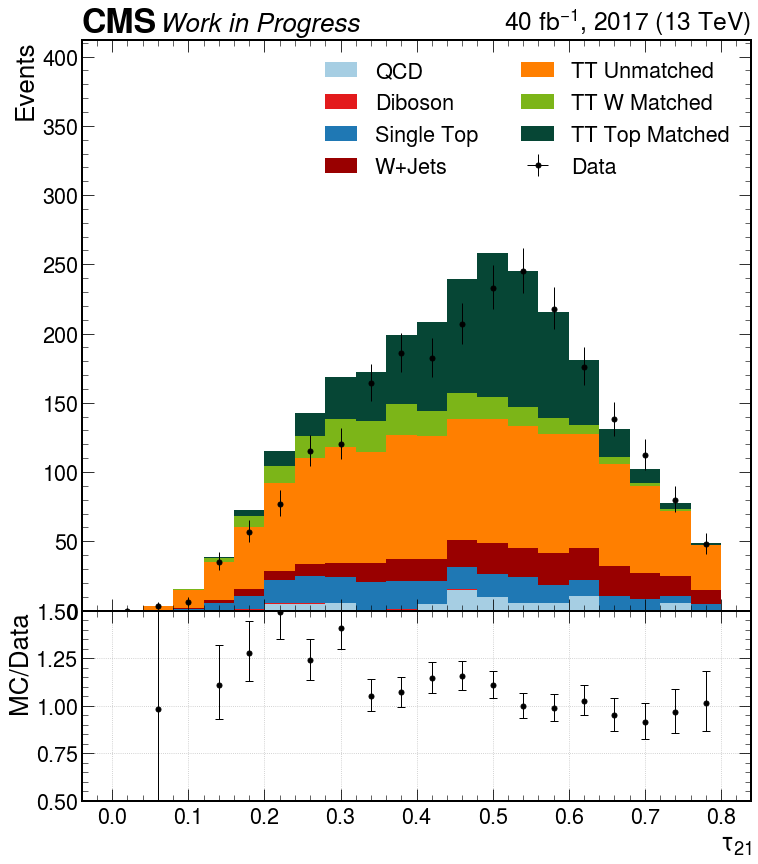

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


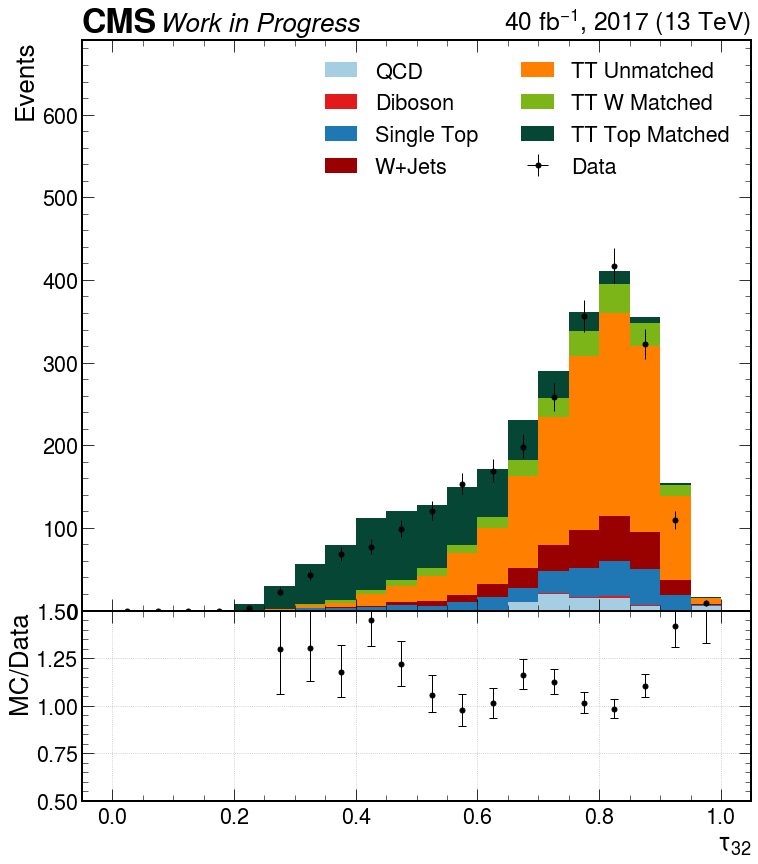

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


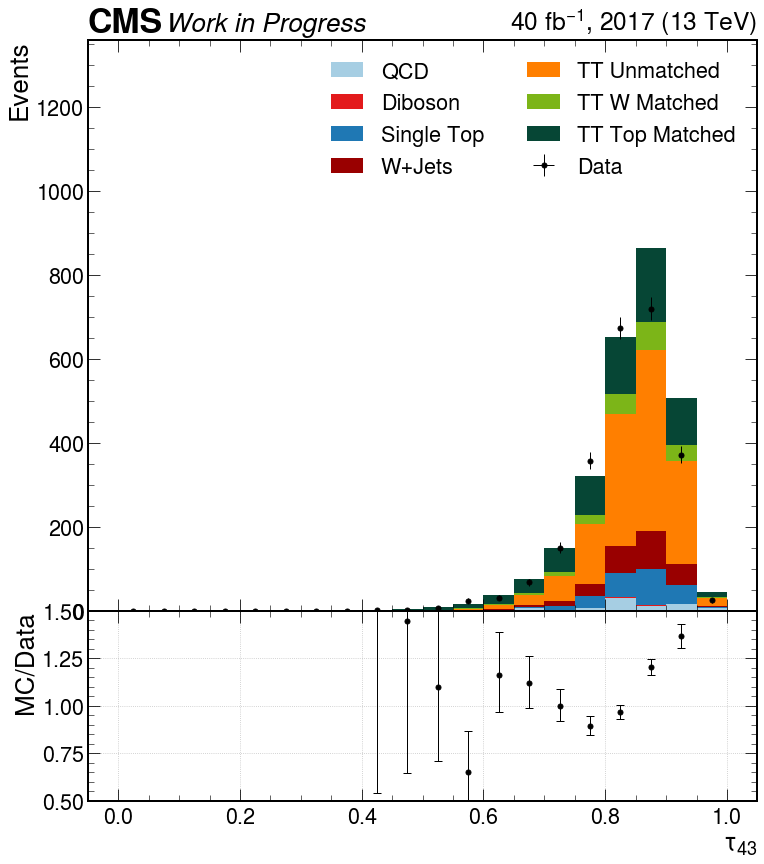

In [159]:
# {var: (bins, label)}
plot_vars = {
    "ak8FatJetMass": ([20, 125, 225], r"$m_{SD}$ (GeV)"),
    "ak8FatJetPt": ([20, 500, 1200], r"$p_T$ (GeV)"),
    "ak8FatJetnPFCands": ([20, 0, 120], r"# of PF Candidates"),
    "ak8FatJetParticleNet_Th4q": ([20, 0, 1], r"ParticleNet $T_{H4q}$ Non-MD"),
    "tau21": ([20, 0, 0.8], r"$\tau_{21}$"),
    "tau32": ([20, 0, 1], r"$\tau_{32}$"),
    "tau43": ([20, 0, 1], r"$\tau_{43}$"),
}

pre_hists = {}

for var, (bins, label) in plot_vars.items():
    if var not in pre_hists:
        pre_hists[var] = utils.singleVarHistNoMask(
            events_dict, var, bins, label, weight_key="weight"
        )

merger_pre_plots = PdfFileMerger()

for var, var_hist in pre_hists.items():
    name = f"{plot_dir}/pre_{var}.pdf"
    plotting.ratioHistPlot(
        var_hist,
        plot_samples,
        name=name,
    )
    merger_pre_plots.append(name)

merger_pre_plots.write(f"{plot_dir}/PrePlots.pdf")
merger_pre_plots.close()

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


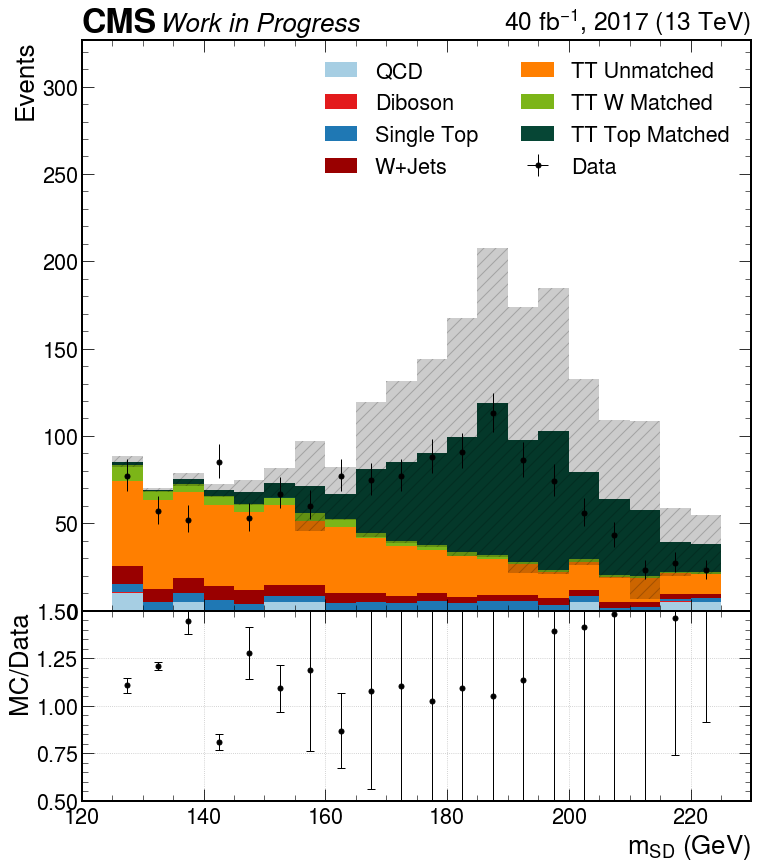

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


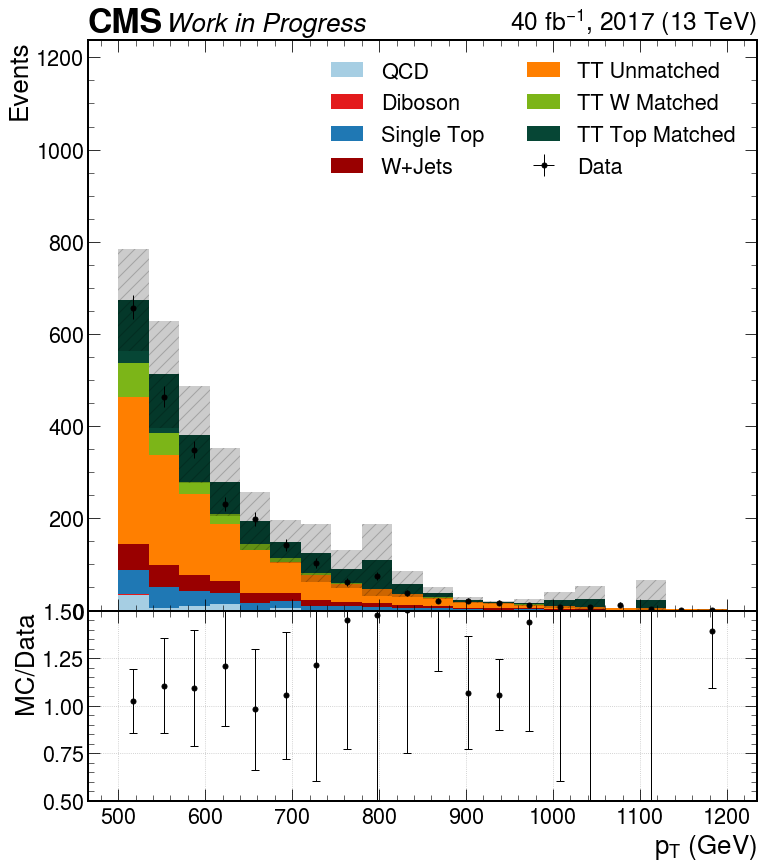

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


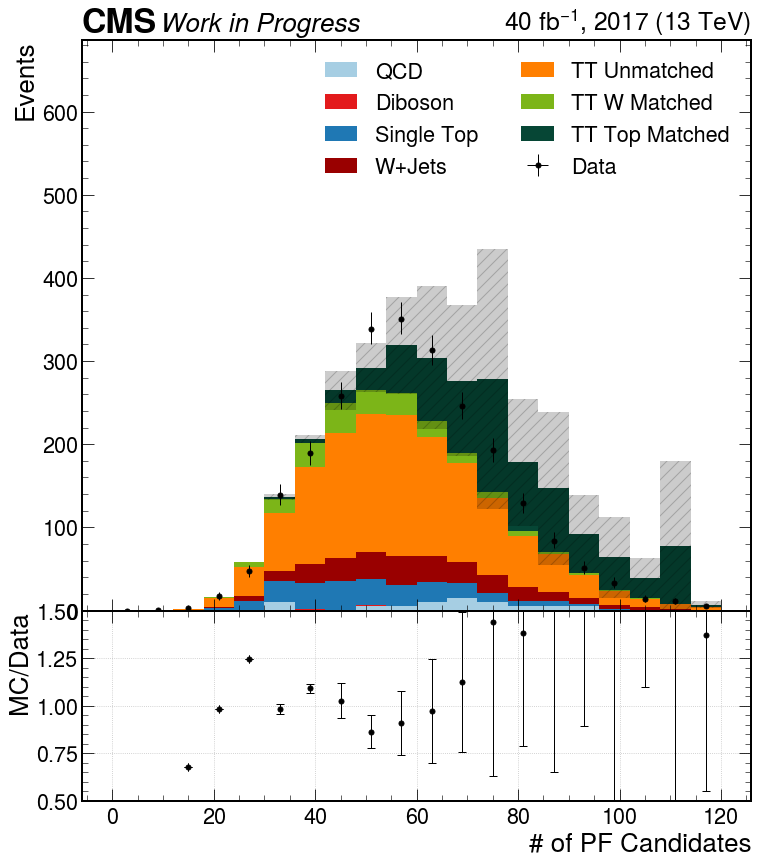

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


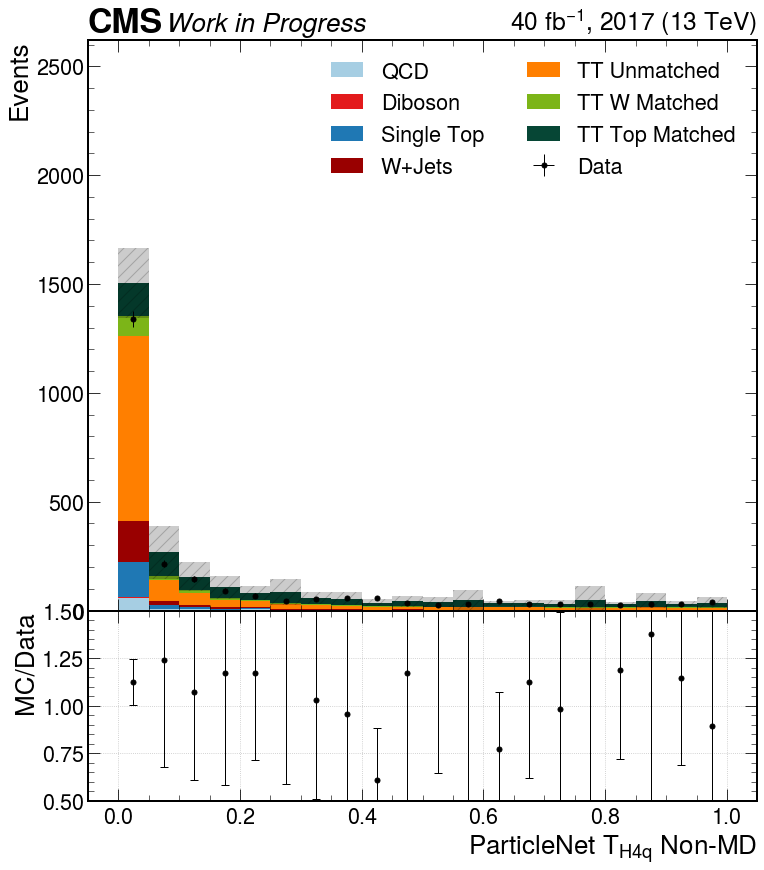

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


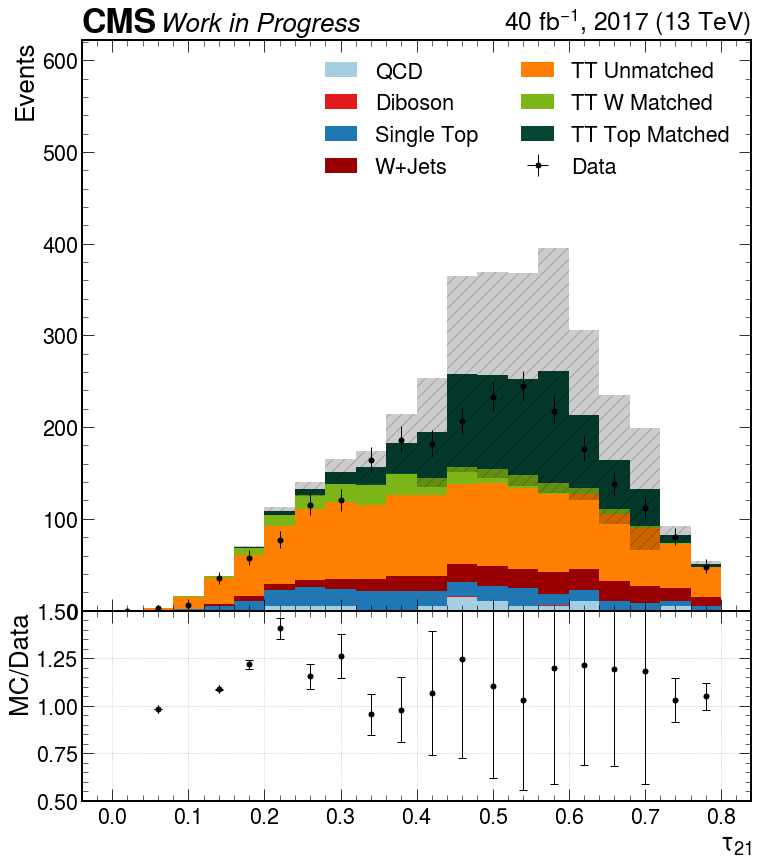

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


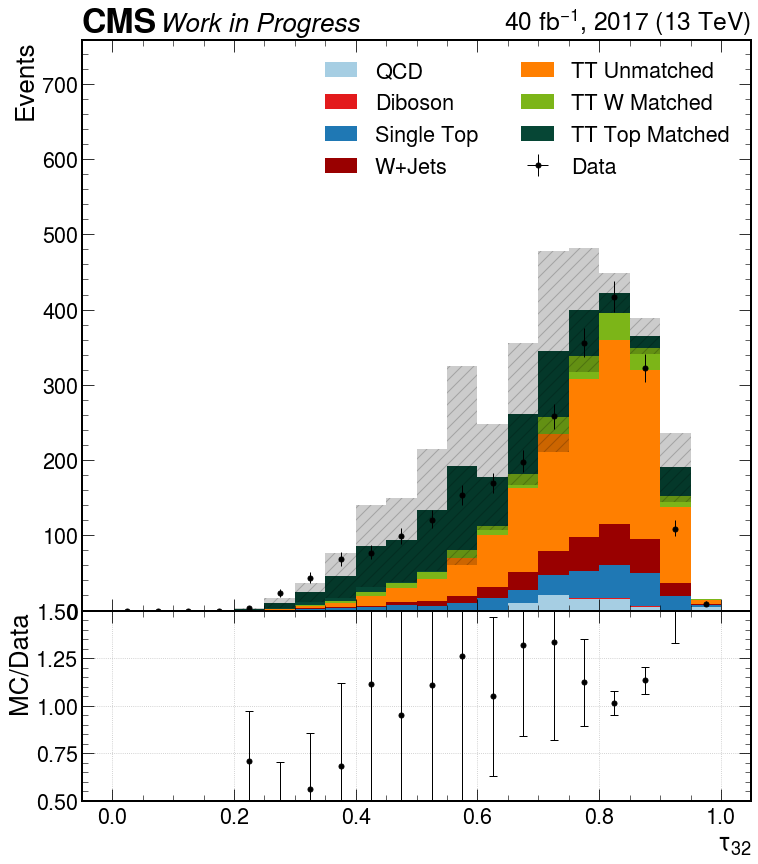

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


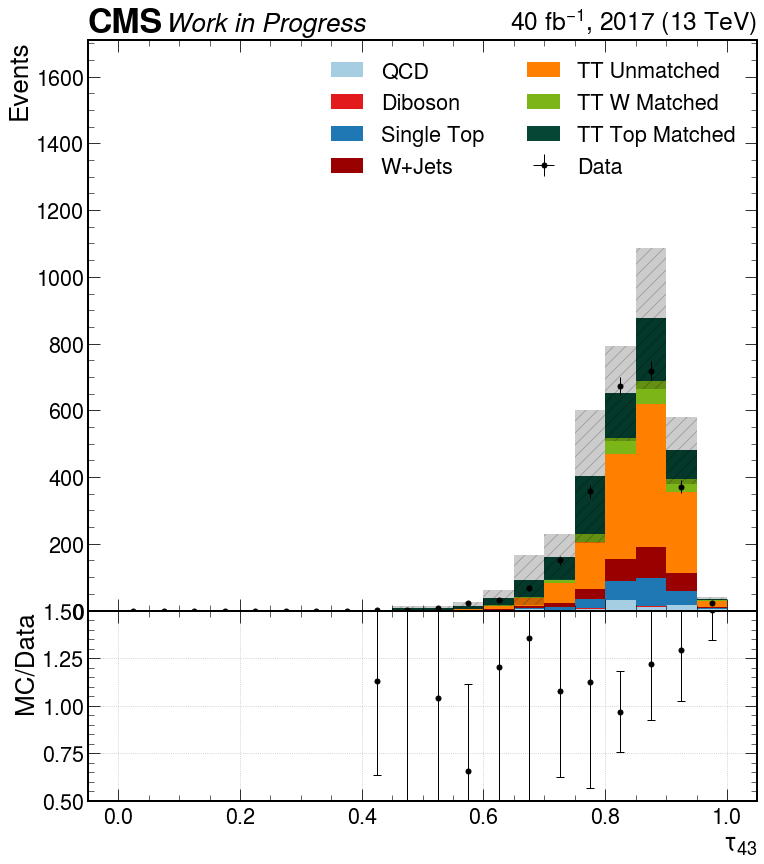

In [160]:
post_hists = {}
post_hists_err = {}

for var, (bins, label) in plot_vars.items():
    if var not in post_hists:
        post_hists[var] = utils.singleVarHistNoMask(
            events_dict, var, bins, label, weight_key="total_weight"
        )
        post_hists_err[var] = utils.singleVarHistNoMask(
            events_dict, var, bins, label, weight_key="total_weight_err"
        )

merger_post_plots = PdfFileMerger()

for var, var_hist in post_hists.items():
    name = f"{plot_dir}/post_{var}.pdf"
    plotting.ratioHistPlot(
        var_hist,
        plot_samples,
        bg_err=np.sum(post_hists_err[var][plot_samples, :].view(), axis=0)['value'],
        name=name,
    )
    merger_post_plots.append(name)

merger_post_plots.write(f"{plot_dir}/PostPlots.pdf")
merger_post_plots.close()

In [155]:
sum(post_hists_err[var][plot_samples, :], axis=0)

TypeError: 'axis' is an invalid keyword argument for sum()

In [150]:
errs = np.sum(post_hists_err[var][plot_samples, :].values(), axis=0)

[autoreload of plotting failed: Traceback (most recent call last):
  File "/opt/anaconda3/envs/python310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/opt/anaconda3/envs/python310/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/opt/anaconda3/envs/python310/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/raghav/Documents/CERN/hhbbww/HHbbVV/src/HHbbVV/scale_factors/plotting.py", line 112
    yerr = 
        

In [143]:
np.repeat(var_hist.axes[1].edges, 2)[1:-1]

array([125., 125., 130., 130., 135., 135., 140., 140., 145., 145., 150.,
       150., 155., 155., 160., 160., 165., 165., 170., 170., 175., 175.,
       180., 180., 185., 185., 190., 190., 195., 195., 200., 200., 205.,
       205., 210., 210., 215., 215., 220., 220., 225., 225.])

In [132]:
np.sum(post_hists_err[var][plot_samples, :].view(), axis=0)['']

/opt/anaconda3/envs/python310/lib/python3.10/site-packages/boost_histogram/_internal/hist.py:863: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  warnings.warn(


array([(  0.        , 0.00000000e+00), (  0.        , 0.00000000e+00),
       (  0.        , 0.00000000e+00), (  0.        , 0.00000000e+00),
       (  0.        , 0.00000000e+00), (  0.        , 0.00000000e+00),
       (  0.        , 0.00000000e+00), (  0.5014762 , 6.20533865e-02),
       (  0.4930294 , 9.01357352e-02), (  6.73110858, 1.39785345e+01),
       (  7.12108445, 5.06382603e+00), ( 10.50138309, 5.77355007e+00),
       ( 23.43170306, 4.19183060e+01), ( 74.95675887, 1.64540790e+03),
       ( 67.75594854, 6.37256025e+01), (199.92135531, 1.36703594e+03),
       (142.86514482, 2.01044840e+02), (210.79942841, 1.89593185e+03),
       (100.29804217, 5.47996002e+02), (  3.78889509, 1.06876980e+00)],
      dtype=[('value', '<f8'), ('variance', '<f8')])

In [128]:
np.sum(post_hists_err[var].view(), axis=0)['value']

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.5014762 ,
         0.4930294 ,   6.73110858,   7.12108445,  10.50138309,
        23.43170306,  74.95675887,  67.75594854, 199.92135531,
       142.86514482, 210.79942841, 100.29804217,   3.78889509])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x155301e10>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x155302080>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x1553022c0>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x155302500>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x155302740>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x155302980>, errorbar=None, legend_artist=None),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x155302bc0>, errorbar=None, legend_artist=None)]

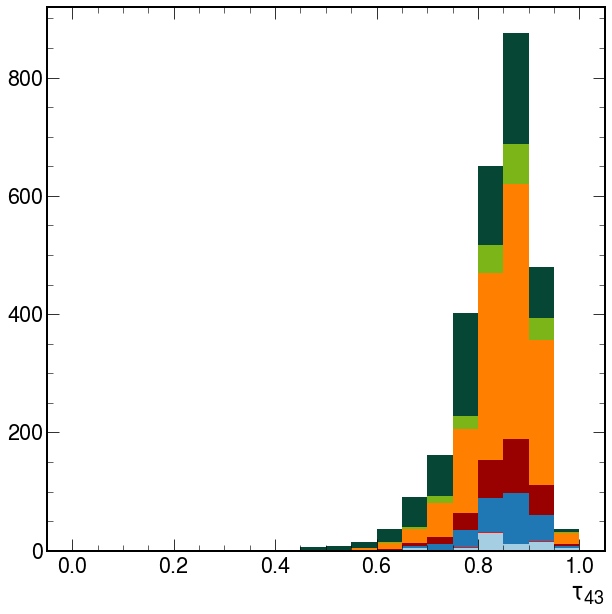

In [129]:
import mplhep as hep

hep.histplot(
        [post_hists[var][sample, :] for sample in plot_samples],
        histtype="fill",
        stack=True,
        label=plot_samples,
        # yerr=np.sum(post_hists_err[var].view(), axis=0)['value'],
        yerr=True,
        color=[plotting.colours[plotting.bg_colours[sample]] for sample in plot_samples],
    )

In [22]:
mass_hist = utils.singleVarHistNoMask(
    events_dict, "ak8FatJetMass", [20, 125, 225], r"$m_{SD}$", weight_key="weight"
)

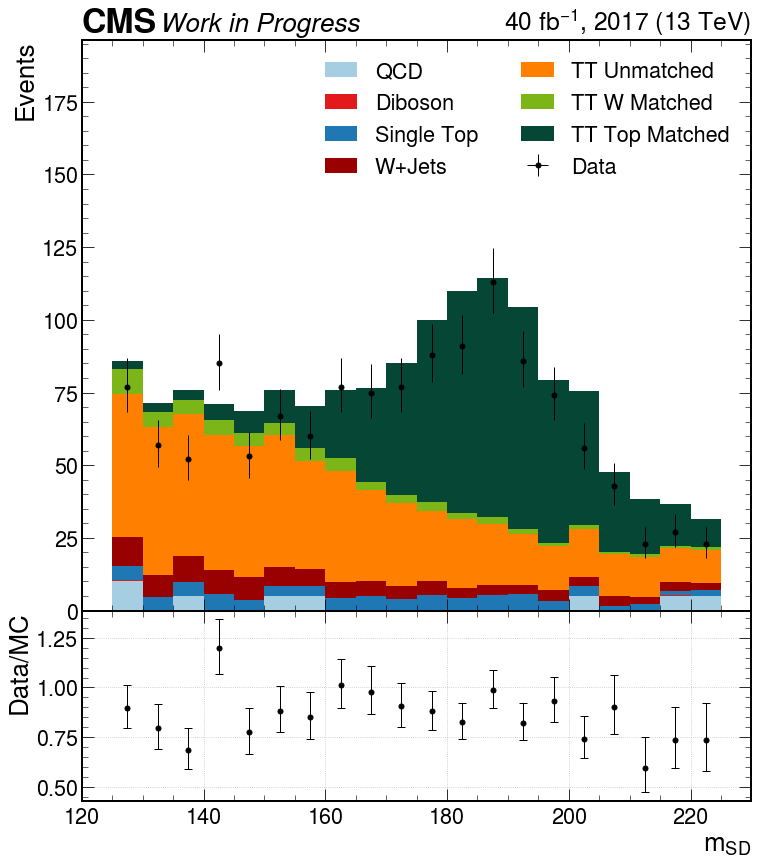

In [26]:
plotting.ratioHistPlot(
    mass_hist,
    ["QCD", "Diboson", "Single Top", "W+Jets", "TT Unmatched", "TT W Matched", "TT Top Matched"],
    f"{plot_dir}/"
)